# CSCI 3202, Spring 2020

# Wednesday January 22, 2020

# In-class notebook:  Agents

<a id='top'></a>

<br>

### Your name(s):

<br>

* When you submit this to Moodle, be sure to include all of your group members' names.
* You may work in groups of up to 5 people,
* but **all people** in the group must submit the assignment on their own Moodle account.

---

Shortcuts:  [Top](#top) || [0](#p0) || [1](#p1) | [1a](#p1a) | [1b](#p1b) | [1c](#p1c) | [1d](#p1d) 

Before you begin, load the packages below (you might find they are handy)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy import stats

<br>

---

## Problem 0

<a/ id='p0'></a>

#### Set up and representing the task environment

Let's design some worlds! Specifically, we want to represent things like a brave knight searching a cave for treasure, or a puppy running around a park, or a Roomba cleaning up a messy house.

This initial part (Problem 0) is going to have a lot of text. But I swear it is worth reading through, because the next few problems will build off of this generic task environment framework.

**Final note:** Many of these problems are intentionally open-ended. Part of the point is to get some practice designing objects, specifically to represent things that are much more overtly "AI" than search algorithms. But (in my view) much more of the point is to **exercise the creative side of programming**. If there was only one answer, it wouldn't be nearly as much fun. 

<br>

First, let's set up some generic classes to represent `Environment`, `Agent` and `Thing`. We have a bunch of methods defined for an `Environment`, all based on what we imagine our needs might be for having an agent running around in the environment, picking things up (vacuuming, eating, holding,...) and putting them back down (a vacuum being full and spitting dirt back out, a puppy putting a bone down so it can drink water,...).

The first 3 methods are used to set up the environment, and populate it with things, or remove things from it:
* constructor: we feed in the dimensions of a square grid environment, and subtract 1 from each to account for the fact that Python is 0-based, but we are sending in the number of tiles in each direction. The lower-left corner of the environment is assumed to be (0,0). The environment can also have `things` and `agents` in it, so we create a list for each of those.
* `add_thing`: we want to be able to add things to the environment. Later, we will look at creating a class to represent `Thing`s.  We need as input to this a Thing and its location (Cartesian coordinates).
* `remove_thing`: we might need to remove some things from the environment. 

The next 3 methods are useful for representing agents' **sensors**. Namely, we are concerned about whether or not the agent can sense things at or near the agent.
* `things_near`: we might be interested to know what are all the things in the tiles *adjacent* to the agent's location (as well as at the agent's location), so we return this as a list.
* `things_at`: perhaps we have an agent that can only sense what is going on in its location (otherwise, the same as `things_near`)
* `percepts`: by default in this generic `Environment` class, the agents will be able to perceive anything *near* them. We can override this later depending on if we think our agent should be able to sense more or less.

We have 3 methods to represent the agent moving through a 2D rectangular grid environment, as well as executing a couple other generic **actions**.
* `hit_wall`: we know the boundaries of the environment, so if the agent tries to move outside of them, we need to let it know that it has bumped into a wall
* `move`: the agent tries to execute a move
* `execute_action`: here is the meat and cheese of the agent's actuators. In this generic class, we allow the agent to move in any of the four cardinal directions, as well as pick things up (`Grab`) and set things down (`Drop`).

Finally, we need a few more methods to define how the actual simulation for the task environment is to proceed.
* `is_done`: returns True if there are no more "living" agents to simulate
* `step`: executes a single time step of the environment: the agent senses the environment, and then acts. This method by default is assuming a single agent, but we could override this to make it more general. You will notice that the `step` method is where we print output to the screen to stay apprised of what is going on in our virtual world.
* `driver`: this is the driver method, which takes as an argument the number of time steps to run (default is 5).


In [2]:
class Environment:

    def __init__(self, width, height):
        self.width = width-1    # relative to 0, so subtract 1
        self.height = height-1
        self.things = []
        self.agents = []

    #
    # The following 2 methods allow us to add Things or remove Things from the environment
    #
    
    def add_thing(self, thing, location):
        '''Add a thing to the environment and set its location.
        For convenience, if thing is an agent program we make a new agent for it.'''
        # first, check if the desired location is in-bounds
        out_of_bounds = (location[0] > self.width or location[0] < 0 or
                         location[1] > self.height or location[1] < 0)
        if out_of_bounds:
            print('Warning: failed to add {} object at {}'.format(thing.__class__.__name__, location))
            return

        if not isinstance(thing, Thing):
            thing = Agent(thing)
        thing.location = location
        self.things.append(thing)
        if isinstance(thing, Agent):
            self.agents.append(thing)

    def remove_thing(self, thing):
        if thing in self.things:
            self.things.remove(thing)
            return True
        elif thing in self.agents:
            self.agents.remove(thing)
            return True
        else:
            return False

    #
    # The next 3 methods set up the agent's perception of things around it (SENSORS)
    #
    
    def things_near(self, location):
        '''return all things around the given location'''
        things = []
        for thing in self.things:  
            # look within a radius of 1 around the agent; on Cartesian grid, 
            # this will only return the Things at the adjacent squares
            # NOTE: if you wanted to let the agent have great vision/better sensors, this
            #       could be modified
            if np.sqrt( (thing.location[0]-location[0])**2 + (thing.location[1]-location[1])**2) <= 1:
                things.append(thing)
        return things
    
    def things_at(self, location):
        '''return all things at the given location'''
        things = []
        for thing in self.things:        
            if thing.location==location:
                things.append(thing)
        return things
    
    def percepts(self, agent):
        '''the agent can perceive things N/S/E/W of their location'''
        return self.things_near(agent.location)

    #
    # The next 3 methods set up how the agent can interact with the environment (ACTUATORS)
    #
    
    def hit_wall(self, location):
        '''hit a wall/boundary if the agent tries to go out of bounds'''
        return (location[0] > self.width or location[0] < 0 or location[1] > self.height or location[1] < 0)
        
    def move(self, agent, direction):
        '''get the new agent location, but revert to old if it bumps into boundary'''
        locx, locy = agent.location
        if direction=='N':
            newLocation = locx, locy+1    
        elif direction=='S':
            newLocation = locx, locy-1
        elif direction=='E':
            newLocation = locx+1, locy
        elif direction=='W':
            newLocation = locx-1, locy
        bump = self.hit_wall(newLocation)
        agent.location = newLocation if not bump else location
        return (not bump)
            
    def execute_action(self, agent, action):
        if action in ['N','S','E','W']:
            bump = self.move(agent, action)
        elif action == 'Grab':
            things = [thing for thing in self.things_at(agent.location)]
            if things:
                agent.holding.append(things[0])
                self.remove_thing(things[0])
        elif action == 'Drop':
            if agent.holding:
                dropped = agent.holding.pop()
                self.add_thing(thing=dropped, location=agent.location)

    #
    # These last 3 methods set up how the simulation for the task environment will be run
    #
    
    def is_done(self):
        '''end the simulation if there are no living agents (or end of time steps)'''
        return not any(agent.is_alive() for agent in self.agents)

    def step(self, quiet):
        '''run one time step of the environment; assumes a single agent'''
        if not self.is_done():
            # assuming a single agent here!
            agent = self.agents[0]
            action = agent.function(self.percepts(agent))
            if not quiet:
                print('Agent {} executes action {} at location {}'.format(agent.name, action, agent.location))
            self.execute_action(agent, action)

    def driver(self, n_steps=5, quiet=False):
        '''a driver method to run the environment for n_steps time steps
        quiet=True will suppress output to screen to update (helpful for long simulations)'''
        for step in range(n_steps):
            self.step(quiet)

Okay, you've made it this far. You deserve a reward.  Here's a picture of a baby sloth wearing pajamas and taking a selfie.

<img src="https://i.pinimg.com/736x/bc/4b/4c/bc4b4c4c01a6a82d8991524c9f41f6ce--pajamas-pjs.jpg" style="width: 200px;"/>


Now then. We should define some generic classes for `Thing`s and `Agent`s.  We can consider an `Agent` to be a subclass of `Thing`, since it is just a special case of general objects that we are putting in our environment.

Our generic `Thing` class is pretty sparse. Basically, we are going to throw down some objects and declare whether or not they are alive. It serves as a basis for representing other things later that we can add other useful attributes to.

In [3]:
class Thing:
    '''represent things in the environment'''
    
    def __init__(self):
        pass
        
    def is_alive(self):
        '''is this thing alive?'''
        return hasattr(self, 'alive') and self.alive

Finally, we can create an `Agent` as a subclass of `Thing`.  We should provide a **name** for our agents, and an **agent function**.  Recall that the agent function is what is "doing the AI". That is, the agent function takes as input the percepts, and provides as output the appropriate agent actions to take.

Note that in case an agent function argument is not provided, we have a nice default course of action for a listless agent. There is also an attribute of the agent to store its `performance` measure, once we decide how to evaluate that.

In [45]:
class Agent(Thing):
    
    def __init__(self, name, agent_function=None):
        self.alive = True
        self.name = name
        self.holding = []
        self.performance = 0
        self.battery = 100
        self.storage = 0
        if agent_function is None:
            print('Warning: Agent {} missing agent_function. Using a silly default.'.format(self.name))
            
            def agent_function(percepts):
                '''Only move left. It is the finest direction, after all.
                Note that this only is run if the user does not supply a valid agent_function'''
                return 'W'

        self.function = agent_function

<br>

---

[Back to top](#top)

<br>

<img src="http://www.irobotweb.com/-/media/Images/Product-Pages/Roomba-Learn/Mini-Compare/960-Product-Image.png?h=292&la=en&w=286" alt="Drawing" style="width: 120px;"/>

<a/ id='p1'></a>
## Problem 1:  Let's talk Roombas.

The generic `Environment`/`Thing`/`Agent` set-up above is a pretty nice framework for tackling a variety of problems, but we will need to override a few components of it to make this function well for the specific task environment of a Roomba cleaning up a dirty room.

First, let's create a **simple reflex agent**, `ReflexRoombaAgent`, method.  This function will take in an argument **name**, representing the agent's name.  Then, an `agent_function` is defined.  This is the most problem-specific part.  The `agent_function` below is specific to our simple two-tile environment that we will play around with initially.  Later, we will modify and extend this to larger rooms, and to other problems.

After defining the `agent_function`, the `ReflexRoombaAgent` constructs an `Agent` object using the generic template above, but with Roomba-specific programming (i.e., `agent_function`).

In [361]:
def ReflexRoombaAgent(name):
    '''reflex Roomba agent. Takes percept as input, which is a tuple of (location, status)
    and returns the appropriate action. This will override the default in the Agent class of 
    only moving West'''
    def agent_function(percepts):
        location, status = percepts
        if status == 'Dirty':
            return 'Vacuum'
        elif location == (0,0):
            return 'E'
        elif location == (1,0):
            return 'W'
        
    return Agent(name, agent_function)        

This Roomba is going to need some `Thing`s to clean up - namely, dirt! So let's create a subclass of `Thing` to represent dirt. If you haven't seen or used the `pass` statement in Python, it is just a placeholder when there needs to be *some*thing in that line, since Python syntax relies on whitespace. (Otherwise, we wouldn't know when to end the definition for the Dirt class.)

In [362]:
class Dirt(Thing):
    pass

Now that we have a Roomba and Dirt, specific to our vacuum task environment, let's make the `Environment` a bit more problem-specific.  The agent interacts with the environment through percepts and actuators, so we will need to override those defaults from the main Environment class. 

For `percepts`, we will assume that the agent can sense (1) its location and (2) whether that location is clean or dirty.  `percepts` takes as the argument the **agent**, and returns a tuple of (**location**, **status**).  Note that the actual "sensing" is done by the `Environment` method `things_at(location)`. That line checks whether or not any of the `things_at` the agent's location are of class Dirt. Note that it is possible to have multiple instances of Dirt in  given location, which could reflect the fact that in real life, sometimes our house is just really gross.

For actuators, the generic `execute_action` method is almost good enough. We can override the `Grab` action with something more meaningful to our application.  Let's rename that as `Vacuum`, and call the things we want to grab `messes`.

We only want the Roomba to pick up things that are Dirt (ideally), so we add the condition `if isinstance(thing, Dirt)`.  Notice that the Roomba will only pick up the *first* unit of dirt that it senses. This reflects the reality that if a tile is *really* dirty, it should take the Roomba longer to clean it up than a just mildly dirty tile.

Notice that we also store in Roomba's `holding` attribute all of the different units of dirt that it has picked up. Later, we will generalize this problem so that Roomba can only store a finite amount of dirt, which is of course how real vacuums work.

In [363]:
class VacuumEnvironment(Environment):
            
    def percepts(self, agent):
        ''' the percept is a tuple of (location, status) '''
        status = 'Dirty' if any([isinstance(item, Dirt) 
                                 for item in room.things_at(location=agent.location)]) else 'Clean'
        return (agent.location, status)

    def execute_action(self, agent, action):
        ''' override the default execute_action in Environment class, so that
        for the Roomba we remove '''
        if action in ['N','S','E','W']:
            bump = self.move(agent, action)
        elif action == 'Vacuum':
            messes = [thing for thing in room.things_at(roomba.location) if isinstance(thing, Dirt)]
            if messes:
                agent.holding.append(messes[0])
                self.remove_thing(messes[0])
        elif action == 'Drop':
            if agent.holding:
                dropped = agent.holding.pop()
                self.add_thing(thing=dropped, location=agent.location)

<br>

<a/ id='p1a'></a>
### (1a)

#### Enough chit chat. Play time!

Create a **room** that is a `VacuumEnvironment` with width=2 and height=1 (i.e., the standard two-tile room from the introductory set of slides where we introduced the concept of agents). Notice that the Cartesian coordinates of the tiles are (0,0) and (1,0), for a width of 2 and height of 1.

In [407]:
room = VacuumEnvironment(width=2, height=1)

If we have a room, and that room can get dirty, we should probably instantiate a `ReflexRoombaAgent`.  Since our `ReflexRoombaAgent` is of class `Agent`, which is a subclass of `Thing`, we will need to use the `add_thing` method to add our Roomba to the **room**.  Here, you can see that we are adding the Roomba to the tile at (0,0).

**Most importantly:** Give your Roomba a sweet name.

In [408]:
roomba = ReflexRoombaAgent('Speedy')
room.add_thing(roomba, location=(0,0))

Finally, to set up the environment, let's sprinkle some dirt around.  In fact, let's set it up so that both tiles are `Dirty`.

In [409]:
room.add_thing(Dirt(), location=(0,0))
room.add_thing(Dirt(), location=(1,0))

At long last, we are ready to actually run our simulation.  Let's run for 6 time steps.

In [410]:
room.driver(6)

Agent Speedy executes action Vacuum at location (0, 0)
Agent Speedy executes action E at location (0, 0)
Agent Speedy executes action Vacuum at location (1, 0)
Agent Speedy executes action W at location (1, 0)
Agent Speedy executes action E at location (0, 0)
Agent Speedy executes action W at location (1, 0)


Okay, that looks like it went smoothly.  We should check that everything is working though.  After 6 time steps, the Roomba should have been able to vacuum up the patches of dirt in both tiles.  Then, what does the agent do? Check out the `agent_function` definition to make sure that, after the agent vacuums up all the dirt, it does what you expect.

We can also check to make sure the list of things in the room, and the list of what all the Roomba agent is holding, both match our expectations.  What should be left in the room?  What should Roomba be holding?  Design a couple `print` statements to check that our task environment looks the way we expect.

In [411]:
print('Things left in the room: {}'.format([thing.__class__.__name__ for thing in room.things]))
print('Things agent is holding: {}'.format([thing.__class__.__name__ for thing in roomba.holding]))

Things left in the room: ['Agent']
Things agent is holding: ['Dirt', 'Dirt']


<br>

Now that we have a basic Roomba agent in a very simple room, let's start to add in layers of complexity/reality. Each part of the rest of this problem adds another feature or set of features to make our Roomba Agents a bit more like actual Roombas.  By the end of this problem, our "toy" Roombas will be pretty similar to actual Roombas.

For the next few parts, my approach would be to only modify the Roomba-specific programming from **Problem 1** and beyond; try to leave the stuff in **Problem 0** alone, if you can. The point of the `ReflexRoombaAgent` and `VacuumEnvironment` classes is to take the generic `Agent` and `Environment` classes and apply vacuum-specific methods, as opposed to hard-coding the entire gory mess from (e.g.) the `Environment` class in **Problem 0**. So, instead of jumping back and forth to modify the codes from **1a**, the easiest thing to do to implement these additional code features is probably to begin by copy-pasting, but then giving the new subclasses here new names.


<br>

<a/ id='p1b'></a>
### (1b)

Also implement the following features. It is probably easiest to do these **one at a time**, to make sure you know which breaks your code if things go off the rails.
1. Include a performance measure for the agent to keep track of.  You should decide for yourselves how you want to measure your Roomba's performance. Here are some general guidelines:
  * Reward cleanliness
  * Penalize excessive moving around
1. Implement a model-based agent
  * Keep track of which tiles are clean/dirty
  * Perhaps use an attribute of the agent called **model** that updates the agent's internal map of where the clean/dirty tiles all are. The entire room is initially unknown.
  * For example, if the Roomba agent has just come from cleaning the tile at (0,0), and has now just cleaned the tile at (1,0), then the Roomba ought to know that going straight back to (0,0) is not the best option.
  * You may want to add a **NoOp** ("no operation" or "do nothing") action choice, since moving around unnecessarily will worsen the agent's performance measure.
1. Stochastically generate new dirt every so often
  * Based on how long it has been since the agent last cleaned a particular tile, it may be necessary to circle back around and check the tiles again for dirt (since it may have appeared stochastically). Thus, the agent will need to track in its model *how long* it has been since it has cleaned each tile.
  * It may be useful to print a message to the screen denoting the location of new dirt, if dirt appears somewhere.

The following code snippet could implement stochastic dirt appearance with probability `p_dirt` for each tile for each time step.  You are encouraged to modify `p_dirt` as you see fit.  The default here is a 1/10 probability of dirt appearing on any given tile at any given time step, possibly from a puppy with muddy paws or a roommate just returning from a hike.  Note that *all* tiles will need to be updated in this way, and that `p_dirt` is probably most appropriate to specify as an attribute of the environment.

In [412]:
p_dirt = 0.1
updateStatus = np.random.choice(['Clean','Dirty'], p=[1-p_dirt, p_dirt])

In [413]:
# Solution:

def ModelBasedRoombaAgent(name, wait_limit=5):
    
    model = {(0,0) : [None,0], (1,0) : [None,0]}

    def agent_function(percepts):
        location, status = percepts
        
        #update the agent's internal model
        model[location][0] = status
        
        # NoOp strategy:
        if all(model[k][0]=='Clean' and model[k][1] <= wait_limit for k in model.keys()):
            for k in model.keys():
                model[k][1] += 1 
            return 'NoOp'
        elif status == 'Dirty':
            for k in model.keys():
                if location==k:
                    model[k][1] = 0
                else:
                    model[k][1] += 1
            return 'Vacuum'
        elif location == (0,0):
            for k in model.keys():
                if location!=k:
                    model[k][1] += 1
            return 'E'
        elif location == (1,0):
            for k in model.keys():
                if location!=k:
                    model[k][1] += 1
            return 'W'
        
    return Agent(name, agent_function)  


class PerformanceVacuumEnvironment(Environment):

    def __init__(self, width, height):
        self.width = width-1    # relative to 0, so subtract 1
        self.height = height-1
        self.things = []
        self.agents = []
        self.p_dirt = 0.1

    def percepts(self, agent):
        ''' the percept is a tuple of (location, status) '''
        status = 'Dirty' if any([isinstance(item, Dirt) 
                                 for item in room.things_at(location=agent.location)]) else 'Clean'
        return (agent.location, status)

    def execute_action(self, agent, action):
        ''' override the default execute_action in Environment class, so that
        for the Roomba we remove '''
        if action in ['N','S','E','W']:
            bump = self.move(agent, action)
            agent.performance -= 1
        elif action == 'Vacuum':
            messes = [thing for thing in room.things_at(roomba.location) if isinstance(thing, Dirt)]
            if messes:
                agent.holding.append(messes[0])
                self.remove_thing(messes[0])
                agent.performance += 10
        elif action == 'Drop':
            if agent.holding:
                dropped = agent.holding.pop()
                self.add_thing(thing=dropped, location=agent.location)
                
    def step(self, quiet):
        '''run one time step of the environment; assumes a single agent'''
        if not self.is_done():
            # assuming a single agent here!
            agent = self.agents[0]
            action = agent.function(self.percepts(agent))
            if not quiet:
                print('Agent {} executes action {} at location {}'.format(agent.name, action, agent.location))
            self.execute_action(agent, action)
            # generate new dirt, maybe
            for x in range(self.width+1):
                for y in range(self.height+1):
                    updateStatus = np.random.choice(['Clean','Dirty'], p=[1-self.p_dirt, self.p_dirt])
                    if updateStatus=='Dirty':
                        self.add_thing(Dirt(), (x,y))
                        if not quiet:
                            print('Dirt appeared at ({},{})!'.format(x,y))

In [414]:
room.things.clear()
roomba.holding.clear()

In [415]:
room = PerformanceVacuumEnvironment(width = 2, height = 1)
roomba = ModelBasedRoombaAgent('R1')

room.add_thing(roomba, (0,0))
room.driver(15)

Agent R1 executes action E at location (0, 0)
Dirt appeared at (0,0)!
Agent R1 executes action NoOp at location (1, 0)
Agent R1 executes action NoOp at location (1, 0)
Agent R1 executes action NoOp at location (1, 0)
Agent R1 executes action NoOp at location (1, 0)
Agent R1 executes action NoOp at location (1, 0)
Agent R1 executes action W at location (1, 0)
Agent R1 executes action Vacuum at location (0, 0)
Dirt appeared at (1,0)!
Agent R1 executes action E at location (0, 0)
Agent R1 executes action Vacuum at location (1, 0)
Agent R1 executes action NoOp at location (1, 0)
Dirt appeared at (1,0)!
Agent R1 executes action Vacuum at location (1, 0)
Agent R1 executes action NoOp at location (1, 0)
Agent R1 executes action NoOp at location (1, 0)
Agent R1 executes action NoOp at location (1, 0)


There should be a relationship between the agent's performance, the frequency with which new dirt stochastically appears (`p_dirt`), and your `NoOp` action strategy (which avoids excessive moving around).  This might be easiest to think about in terms of the limiting cases:
* What should be the agent's `NoOp` strategy if `p_dirt` = 1?
* What should be the agent's `NoOp` strategy if `p_dirt` = 0?

Note that we don't have any control over `p_dirt`; it is a property of how filthy our living conditions are. All we can do is specify the Roomba's `NoOp` strategy (waiting time before circling back to check for new dirt) as best we can.

So, try a few very long simulations (you might want to suppress the printed output for these) with different combinations of `NoOp` strategy and `p_dirt` values.  For a couple different values of `p_dirt`, what do you find to be the optimal `NoOp` strategies? That is, what waiting time (once the agent knows it has cleaned everything) will maximize the agent's performance?

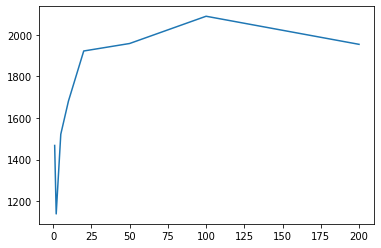

In [416]:
# Solution:

perf = []
wait_limits = [1,2,5,10,20,50,100,200]

for w in wait_limits:
    room = PerformanceVacuumEnvironment(width=2, height=1)
    roomba = ModelBasedRoombaAgent('Rufus', w)
    room.add_thing(roomba, (0,0))
    room.add_thing(Dirt(), (0,0))
    room.add_thing(Dirt(), (1,0))
    room.driver(1000, quiet=True)
    perf.append(np.mean(roomba.performance))

plt.plot(wait_limits, perf)
plt.show()

**Solution:**

Note that your results might vary, depending on your choices for `p_dirt` and the wait limits.  You can also obtain better results by doing this many times and taking the average.

<br>

<a/ id='p1c'></a>

### (1c)

Let's continue to build this up! We can make things a bit more interesting by increasing the size of the room. Add the following features to your codes from **(1b)**:
* Try a 2x2 room first.
* In the example codes, Roomba knew the geography of the environment (i.e., that it is a 2x1 room), so it knew the options for moving around.
  * As a first attempt for your 2x2 room, make this assumption.  Thus, the Roomba's choices of action to execute will depend on its sensed location.
    * Note that if Roomba is at (0,0), and senses that this tile is clean, but has no information about (1,0) or (0,1), then it should choose at random where to go next. A modification of the `np.random.choice` function call above can take care of this.
  * Once that seems to work, try to incorporate the fact that the Roomba typically does not know a priori what the shape of the room is. 
    * The easiest first step to build this into your model is to have Roomba sense its environment: if dirty, then clean the tile; if clean, then move randomly. (This is how I clean my apartment.)
    * Then you can try building a **map** of the room as part of the Roomba's model. So as the random-movement Roomba flails around, it will sometimes bump into a wall.  But if it senses a bump, then Roomba can *learn* where the walls are, and what the available actions are depending on where in the room it is.
    * Holy heck, we just built a *learning* model-based agent!
* Once your Roomba is successfully tidying up a 2x1 or 2x2 room, go bigger!
* It might be useful to note that the only thing that really needs to change is your `agent_function`, which maps percepts to actions. The `VacuumEnvironment` class is already able to handle arbitrary-sized rooms. So selecting an action will need to be modified, as well as how the agent builds its internal model of the task environment.

In [417]:
# Solution:

def MBRA2(name, wait_limit=5):
    
    model = {(0,0) : [None,0], (1,0) : [None,0],
             (0,1) : [None, 0] , (1,1) : [None, 0]}
    
    # Construct an internal map as the Roomba bumps into walls
    
    def agent_function(percepts):
        location, status = percepts
        
        #update the agent's internal model
        model[location][0] = status
        
        # NoOp strategy:
        if all(model[k][0]=='Clean' and model[k][1] <= wait_limit for k in model.keys()):
            for k in model.keys():
                model[k][1] += 1 
            return 'NoOp'
        
        elif status == 'Dirty':
            for k in model.keys():
                if location==k:
                    model[k][1] = 0
                else:
                    model[k][1] += 1
            return 'Vacuum'
        
        elif location == (0,0):
            for k in model.keys():
                if location!=k:
                    model[k][1] += 1
            return np.random.choice(['N', 'E'], p = [0.5, 0.5])
        
        elif location == (1,0):
            for k in model.keys():
                if location!=k:
                    model[k][1] += 1
            return np.random.choice(['N', 'W'], p = [0.5, 0.5])
        
        elif location == (0, 1):
            for k in model.keys():
                if location != k:
                    model[k][1] += 1
            return np.random.choice(['S', 'E'], p = [0.5, 0.5])
        
        elif location == (1,1):
            for k in model.keys():
                if location != k:
                    model[k][1] += 1
            return np.random.choice(['S', 'W'], p = [0.5, 0.5])
        
    return Agent(name, agent_function) 

In [418]:
print('Things left in the room: {}'.format([thing.__class__.__name__ for thing in room.things]))
print('Things agent is holding: {}'.format([thing.__class__.__name__ for thing in roomba.holding]))

Things left in the room: ['Agent', 'Dirt', 'Dirt']
Things agent is holding: ['Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Di

In [419]:
roomba.holding.clear()
room.things.clear()

In [420]:
print('Things left in the room: {}'.format([thing.__class__.__name__ for thing in room.things]))
print('Things agent is holding: {}'.format([thing.__class__.__name__ for thing in roomba.holding]))

Things left in the room: []
Things agent is holding: []


In [421]:
# Performance increase by a factor of about 2 for 2x2 grid implementation, with a peak performance at the spot where 
# performance was minimal in the 1st model-based implementation

room = PerformanceVacuumEnvironment(width = 2, height = 2)
roomba = MBRA2('R2')

room.add_thing(roomba, (0,0))
room.driver(15)

Agent R2 executes action E at location (0, 0)
Dirt appeared at (0,1)!
Dirt appeared at (1,1)!
Agent R2 executes action W at location (1, 0)
Agent R2 executes action E at location (0, 0)
Agent R2 executes action W at location (1, 0)
Agent R2 executes action E at location (0, 0)
Agent R2 executes action W at location (1, 0)
Agent R2 executes action N at location (0, 0)
Dirt appeared at (0,1)!
Dirt appeared at (1,0)!
Agent R2 executes action Vacuum at location (0, 1)
Agent R2 executes action Vacuum at location (0, 1)
Dirt appeared at (1,1)!
Agent R2 executes action E at location (0, 1)
Agent R2 executes action Vacuum at location (1, 1)
Agent R2 executes action Vacuum at location (1, 1)
Agent R2 executes action S at location (1, 1)
Agent R2 executes action Vacuum at location (1, 0)
Agent R2 executes action W at location (1, 0)
Dirt appeared at (0,1)!


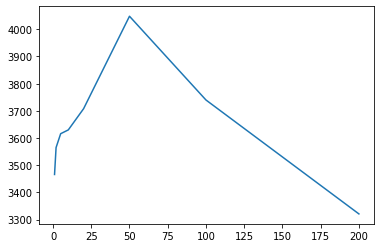

In [422]:
perf_1c = []
for w in wait_limits:
    room = PerformanceVacuumEnvironment(width=2, height=2)
    roomba = MBRA2('Rufus', w)
    room.add_thing(roomba, (0,0))
#     room.add_thing(Dirt(), (0,0))
#     room.add_thing(Dirt(), (1,0))
    room.driver(1000, quiet=True)
    perf_1c.append(np.mean(roomba.performance))

plt.plot(wait_limits, perf_1c)
plt.show()

In [423]:
print('Things left in the room: {}'.format([thing.__class__.__name__ for thing in room.things]))
print('Things agent is holding: {}'.format([thing.__class__.__name__ for thing in roomba.holding]))

Things left in the room: ['Agent', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt']
Things agent is holding: ['Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Di

In [424]:
roomba.holding.clear()
room.things.clear()

In [425]:
print('Things left in the room: {}'.format([thing.__class__.__name__ for thing in room.things]))
print('Things agent is holding: {}'.format([thing.__class__.__name__ for thing in roomba.holding]))

Things left in the room: []
Things agent is holding: []


<br>

<a/ id='p1d'></a>

### (1d)

Let's add two more related details that will really make this Roomba more realistic.
* Roombas have a certain amount of **charge**, which depletes as time goes on. You could incorporate this into the model in a few different ways. Use your ingenuity and creativity to decide how to implement this! If you get stuck, ask other groups or ask me.
  * This means that your Roomba is going to need a particular location as a charging spot, and should return to it every so often.
  * It is probably reasonable to assume that your Roomba knows how long (how many time steps) it takes to deplete its battery. As part of Roomba's model, it should keep track of how long it will take to return to the charging port and how much battery life remains.
  * If the battery falls below a critical point, return to base!
  * What should happen if the battery is fully depleted?
* Roombas also can only hold a **finite amount of dirt**.
  * If the dirt gets "full" (you will need to implement some dirt limit as part of the agent), then the Roomba can't vacuum anymore and needs to return to the charging port to dump its dirt.

In [426]:
def MBRA3(name, wait_limit = 5):
    
    model = {(0,0) : [None, 0] , (0,1) : [None, 0],
             (1,0) : [None, 0] , (1,1) : [None, 0]}

    def agent_function(percepts):
        
        location, status = percepts

        model[location][0] = status
        
        if all(model[k][0] == 'Clean' and model[k][1] <= wait_limit for k in model.keys()):
            for k in model.keys():
                model[k][1] += 1
            return 'NoOp'
        
        elif status == 'Dirty':
            for k in model.keys():
                if location == k:
                    model[k][1] = 0
                else:
                    model[k][1] += 1
            return 'Vacuum'
        
        elif location == (0,0):
            for k in model.keys():
                if location != k:
                    model[k][1] += 1
            return np.random.choice(['N', 'E'], p = [0.5, 0.5])
        
        elif location == (0,1):
            for k in model.keys():
                if location != k:
                    model[k][1] += 1
            return np.random.choice(['S', 'E'], p = [0.5, 0.5])
                
        elif location == (1,0):
            for k in model.keys():
                if location != k:
                    model[k][1] += 1
            return np.random.choice(['N', 'W'], p = [0.5, 0.5])
                
        elif location == (1,1):
            for k in model.keys():
                if location != k:
                    model[k][1] += 1
            return np.random.choice(['S', 'W'], p = [0.5, 0.5])
        
    return Agent(name, agent_function)

# class PerformanceVacuumEnvironment3(Environment):

#     def __init__(self, width, height):
#         self.width = width-1    # relative to 0, so subtract 1
#         self.height = height-1
#         self.things = []
#         self.agents = []
#         self.p_dirt = 0.1

#     def percepts(self, agent):
#         ''' the percept is a tuple of (location, status) '''
#         status = 'Dirty' if any([isinstance(item, Dirt) 
#                                  for item in room.things_at(location=agent.location)]) else 'Clean'
#         return (agent.location, status)


#     # If the agent vacuums, then battery life decreases by 2 percent. For any move, battery decreases by 1.
#     def execute_action(self, agent, action):
#         ''' override the default execute_action in Environment class, so that
#         for the Roomba we remove '''
#         # Before executing an action, we must now check to see if the roomba has sufficient battery as well as
#         # dirt storage.
#         if(agent.battery <= 6) or (agent.storage == 100):
#             # Roomba needs to return to home base to charge/dump
#             agent.location == (0,0)
#             agent.storage = 0
#             agent.battery = 100
#             agent.holding.clear()

#         if action in ['N','S','E','W']:
#             bump = self.move(agent, action)
#             agent.performance -= 1
#             agent.battery -= 1 # Loses 1% battery for a move
            
#         elif action == 'Vacuum':
#             messes = [thing for thing in room.things_at(roomba.location) if isinstance(thing, Dirt)]
#             if messes:
#                 agent.holding.append(messes[0])
#                 self.remove_thing(messes[0])
#                 agent.performance += 10
#                 agent.battery -= 2 # Loses 2% battery for a vacuum
#                 agent.storage += 1 # Collect 1 "dirt"
#         elif action == 'Drop':
#             if agent.holding:
#                 dropped = agent.holding.pop()
#                 self.add_thing(thing=dropped, location=agent.location)
#                 agent.storage = 0 # Empty dirt storage
                
#     def step(self, quiet):
#         '''run one time step of the environment; assumes a single agent'''
#         if not self.is_done():
#             # assuming a single agent here!
#             agent = self.agents[0]
#             action = agent.function(self.percepts(agent))
#             if not quiet:
#                 print('Agent {} executes action {} at location {}'.format(agent.name, action, agent.location))
#             self.execute_action(agent, action)
#             # generate new dirt, maybe
#             for x in range(self.width+1):
#                 for y in range(self.height+1):
#                     updateStatus = np.random.choice(['Clean','Dirty'], p=[1-self.p_dirt, self.p_dirt])
#                     if updateStatus=='Dirty':
#                         self.add_thing(Dirt(), (x,y))
#                         if not quiet:
#                             print('Dirt appeared at ({},{})!'.format(x,y))


In [427]:
room = PerformanceVacuumEnvironment(width = 2, height = 2)
roomba = MBRA3('R3')

room.add_thing(roomba, (0,0))

room.driver(15)

Agent R3 executes action N at location (0, 0)
Agent R3 executes action E at location (0, 1)
Agent R3 executes action S at location (1, 1)
Agent R3 executes action NoOp at location (1, 0)
Dirt appeared at (0,0)!
Dirt appeared at (1,1)!
Agent R3 executes action NoOp at location (1, 0)
Agent R3 executes action NoOp at location (1, 0)
Agent R3 executes action N at location (1, 0)
Dirt appeared at (0,0)!
Agent R3 executes action Vacuum at location (1, 1)
Agent R3 executes action W at location (1, 1)
Dirt appeared at (1,0)!
Agent R3 executes action E at location (0, 1)
Agent R3 executes action W at location (1, 1)
Dirt appeared at (1,0)!
Dirt appeared at (1,1)!
Agent R3 executes action E at location (0, 1)
Agent R3 executes action Vacuum at location (1, 1)
Dirt appeared at (1,0)!
Agent R3 executes action S at location (1, 1)
Dirt appeared at (1,1)!
Agent R3 executes action Vacuum at location (1, 0)
Dirt appeared at (0,1)!


In [428]:
print('Things left in the room: {}'.format([thing.__class__.__name__ for thing in room.things]))
print('Things agent is holding: {}'.format([thing.__class__.__name__ for thing in roomba.holding]))

Things left in the room: ['Agent', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt', 'Dirt']
Things agent is holding: ['Dirt', 'Dirt', 'Dirt']


In [405]:
roomba.holding.clear()
room.things.clear()

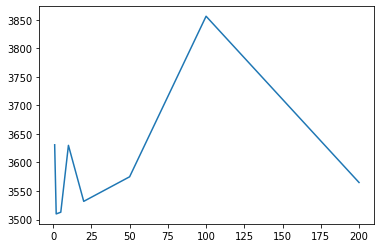

In [406]:
perf_1d = []
wait_limits = [1,2,5,10,20,50,100,200]

for w in wait_limits:
    room = PerformanceVacuumEnvironment(width=2, height=2)
    roomba = MBRA3('Rob', w)
    room.add_thing(roomba, (0,0))
#     room.add_thing(Dirt(), (0,0))
#     room.add_thing(Dirt(), (1,0))
    room.driver(1000, quiet=True)
    perf_1d.append(np.mean(roomba.performance))

plt.plot(wait_limits, perf_1d)
plt.show()